In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import importlib

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten

from lstm_model import*

import sys
sys.path.insert(0, '../')
from data_preparation import *

Using TensorFlow backend.


In [4]:
from numpy.random import seed
seed(12345)
from tensorflow import set_random_seed
set_random_seed(12345)

In [5]:
train_1 = pd.read_csv("../../web-traffic-time-series-forecasting/train_1.csv")
data = data_per_date(train_1)

# LSTM on single pages

In [6]:
N_of_pages = 8
page = {}
titles = list()


for i in range(N_of_pages):
    titles.append(data['Page'][np.random.randint(0,len(data))])

for i in range(N_of_pages):
    page[i] = find_page(data, titles[i])

In [7]:
import time
start = time.time()

all_history = {}
all_models = {}
lookback = 1
size = int(0.80*len(page[0]))
i = 0


for i in range(N_of_pages):

    
    train, test = series_split(page[i], size)
    scaler, train_scaled, test_scaled = scale(train, test)
    

    #print("Starting modelling page %d out of %d" %(i+1, N_of_pages))

    lstm_model, history = fit_simple_lstm(train_scaled, last = test_scaled[0], units = 50,\
                                             batch_size = 20, nb_epochs = 20, \
                                             lookback = lookback)
    
    all_models[i] = lstm_model
    all_history[i] = history
    #print("Model completed for page %d out of %d" %(i+1, N_of_pages))

end = time.time()
print("total elapsed time:", end - start)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
total elapsed time: 28.53632116317749


In [8]:
test_predictions = {}
univariate_smape = {}

for i in range(N_of_pages):
    train, test = series_split(page[i], size)
    scaler, train_scaled, test_scaled = scale(train, test)
    
    X_test, y_test = create_dataset(test_scaled, test_scaled[-1],lookback)
    
    test_predictions[i] = all_models[i].predict(X_test, batch_size = 20)
    
    test_predictions[i] = scaler.inverse_transform(test_predictions[i])
    X_test[0:,0] = scaler.inverse_transform(X_test[0:,0])
    
    univariate_smape[i] = smape(X_test[0:,0], test_predictions[i])

print('------------------------')
print('Test SMAPE:', np.array(list(univariate_smape.values())).mean())
print('------------------------')

------------------------
Test SMAPE: 39.25618578939314
------------------------


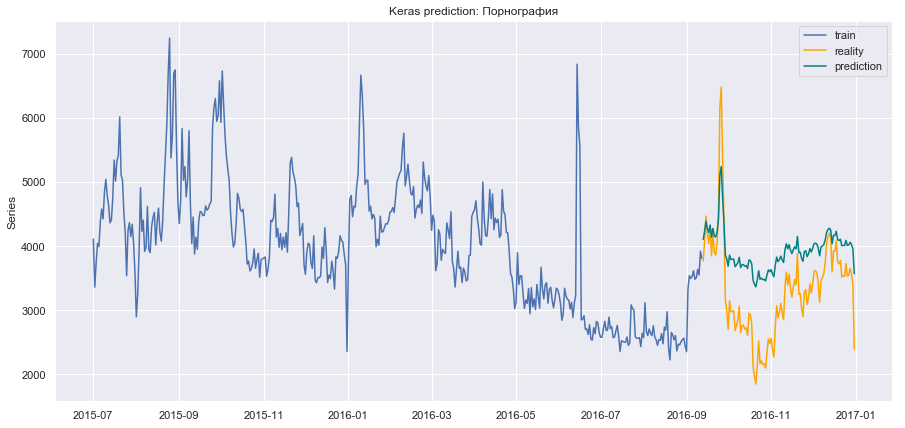

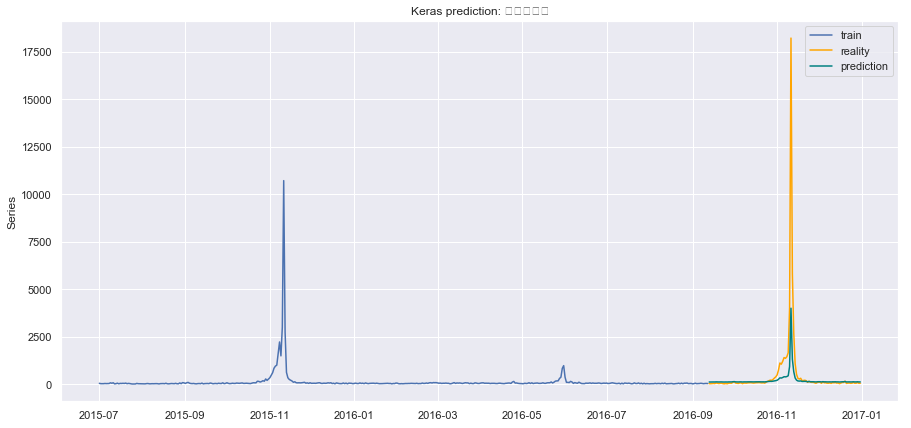

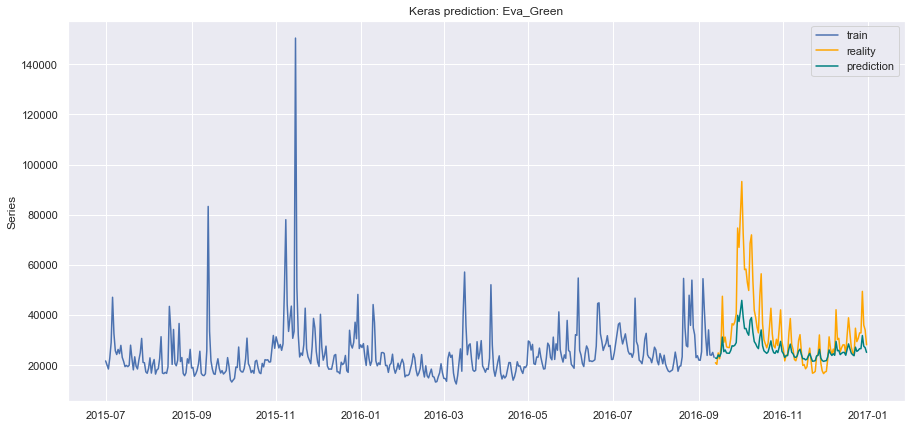

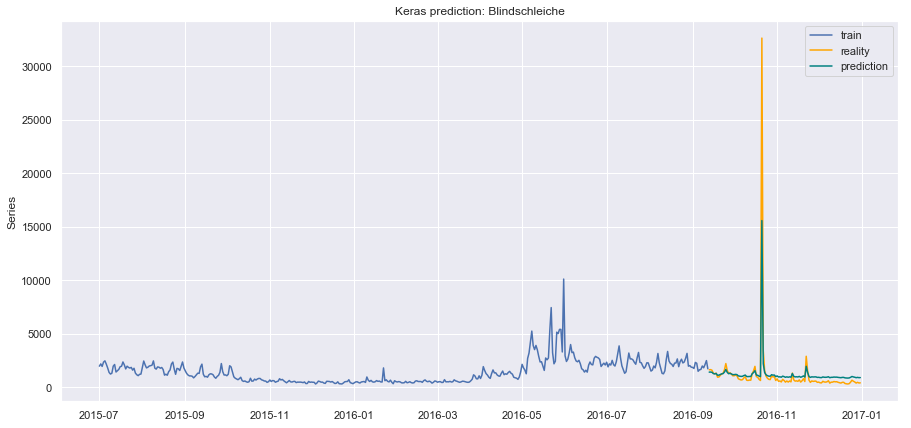

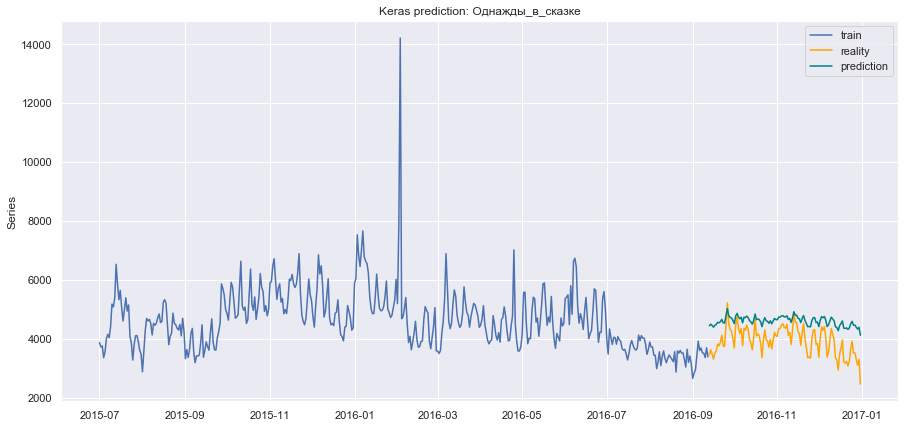

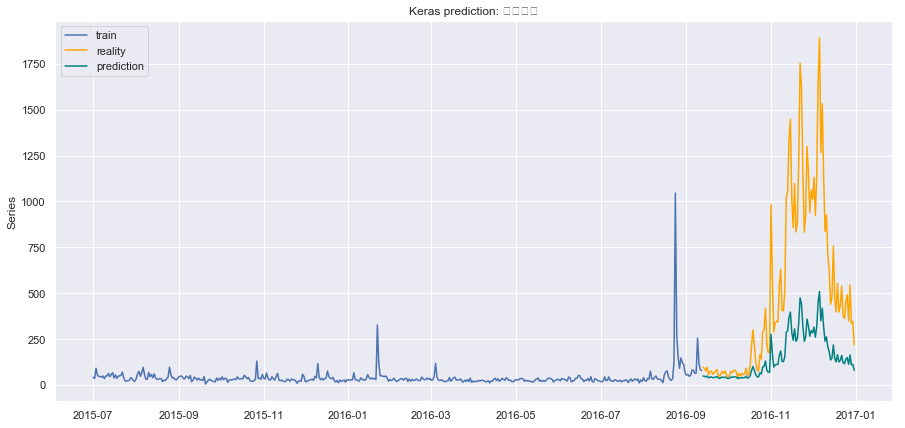

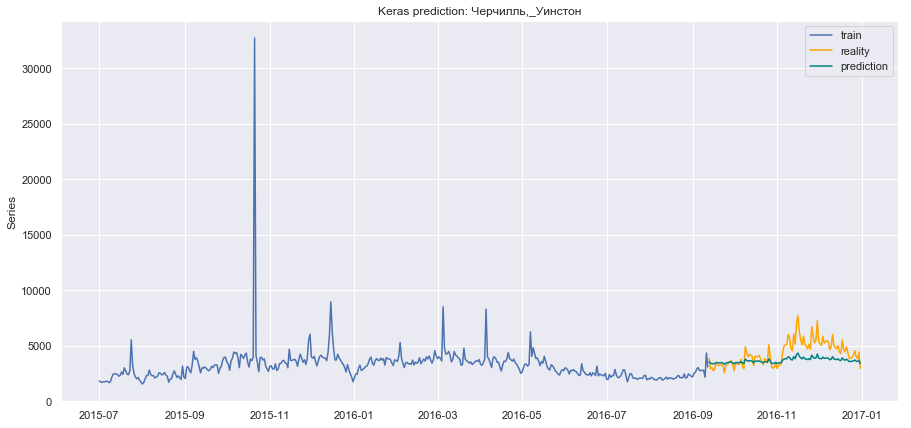

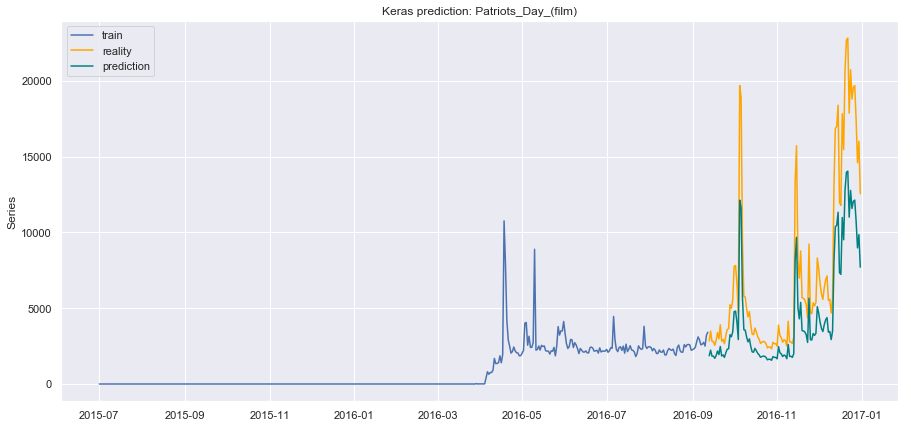

In [9]:
for i in range(N_of_pages):
        
    train, test = series_split(page[i], size)
    scaler, train_scaled, test_scaled = scale(train, test)
    
    X_train, y_train = create_dataset(train_scaled,test_scaled[0],1)
    X_test, y_test = create_dataset(test_scaled,test_scaled[-1], 1)
    X_test[0:,0] = scaler.inverse_transform(X_test[0:,0])
    
    
    plot_keras(train, test, X_test, test_predictions[i], lookback, titles[i])  


# Seq2Seq anlysis of the whole dataset

In [10]:
N_of_pages = 3000
page2 = {}
titles = {}

page2, titles = extract_series(train_1, N_of_pages)

In [11]:
size = int(len(page2[0])*0.891)
timestep = int((len(page2[0]) - size)/2)

train_enc_start = 0
train_enc_end = size

train_pred_start = size
train_pred_end = size + timestep


val_enc_start = timestep 
val_enc_end = size + timestep

val_pred_start = size + timestep
val_pred_end = size + 2*timestep

In [12]:
scaler, encoder_input_train, decoder_X_train, \
    decoder_y_train = get_encod_decod(page2, train_enc_start,train_enc_end,\
                                      train_pred_start, train_pred_end)

In [13]:
import time
start = time.time()

all_models2, all_history2, encoder_model, decoder_model = fit_se2seq(encoder_input_train, \
                                                  decoder_X_train, decoder_y_train,\
                                                  epochs=100, batch_size = 2048)

end = time.time()
print("total elapsed time:", end - start)

Train on 2400 samples, validate on 600 samples
Epoch 1/100
2400/2400 [==============================] - 17s 7ms/step - loss: 0.1021 - val_loss: 0.0821
Epoch 2/100
2400/2400 [==============================] - 12s 5ms/step - loss: 0.0828 - val_loss: 0.0693
Epoch 3/100
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0713 - val_loss: 0.0656
Epoch 4/100
2400/2400 [==============================] - 8s 4ms/step - loss: 0.0687 - val_loss: 0.0668
Epoch 5/100
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0712 - val_loss: 0.0670
Epoch 6/100
2400/2400 [==============================] - 6s 3ms/step - loss: 0.0713 - val_loss: 0.0649
Epoch 7/100
2400/2400 [==============================] - 8s 3ms/step - loss: 0.0695 - val_loss: 0.0624
Epoch 8/100
2400/2400 [==============================] - 6s 3ms/step - loss: 0.0674 - val_loss: 0.0609
Epoch 9/100
2400/2400 [==============================] - 6s 3ms/step - loss: 0.0650 - val_loss: 0.0607
Epoch 10/100
2400/2400 [

In [14]:
all_models2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, 50), (None,  10400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, None, 50), ( 10400       input_2[0][0]                    
                                                                 lstm_9[0][1]                     
          

In [15]:
_, encoder_input_test, decoder_X_test, \
    decoder_y_test = get_encod_decod(page2,  val_enc_start,val_enc_end,\
                                     val_pred_start, val_pred_end)

In [16]:
pred_sequences = {}
for i in range(encoder_input_test.shape[0]):
    encode_series = encoder_input_test[i:i+1,:,:]
    pred_sequences[i] = decode_sequence(encode_series, \
                                       encoder_model, decoder_model, timestep)
    pred_sequences[i] = pred_sequences[i].reshape(-1, 1)

In [17]:
multivariate_smape = {}

for i in page2.keys():
    train, test = series_split(page2[i], size+timestep)

    pred_sequences[i] = scaler[i].inverse_transform(pred_sequences[i])

    multivariate_smape[i] = smape(test.values, pred_sequences[i])

print('------------------------')
print('Test SMAPE:', np.array(list(multivariate_smape.values())).mean())
print('------------------------')

------------------------
Test SMAPE: 65.32320758208891
------------------------


In [18]:
arr = np.array(list(page2.keys())) 
arr = arr[arr < 100]

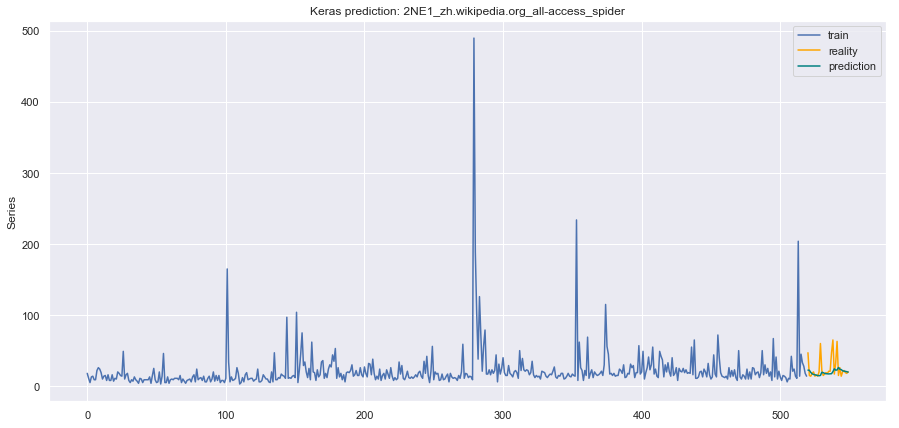

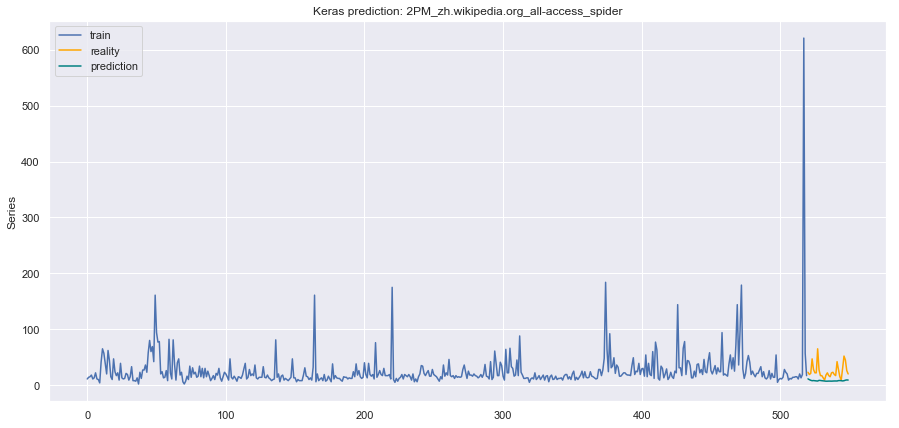

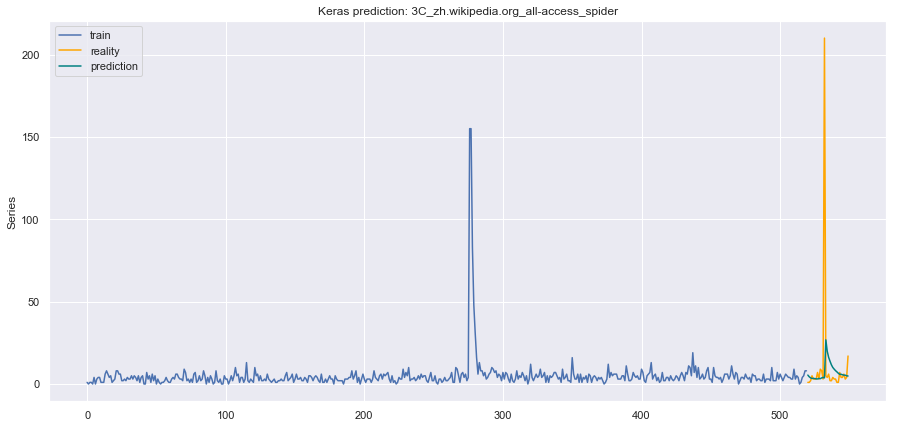

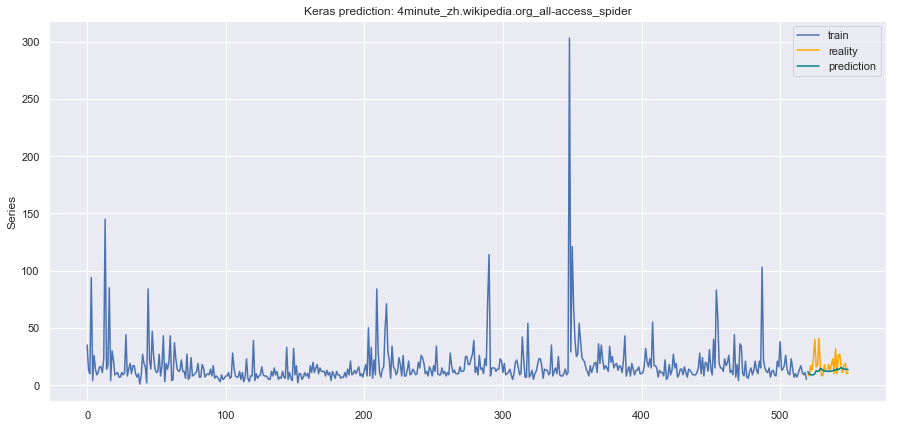

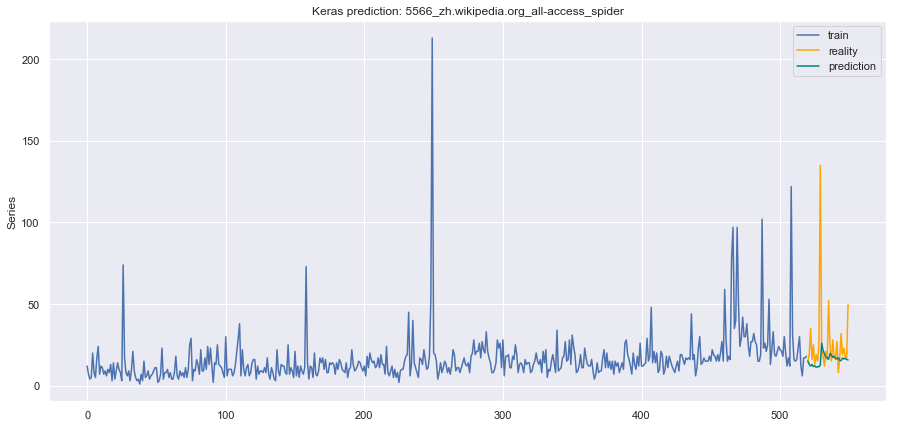

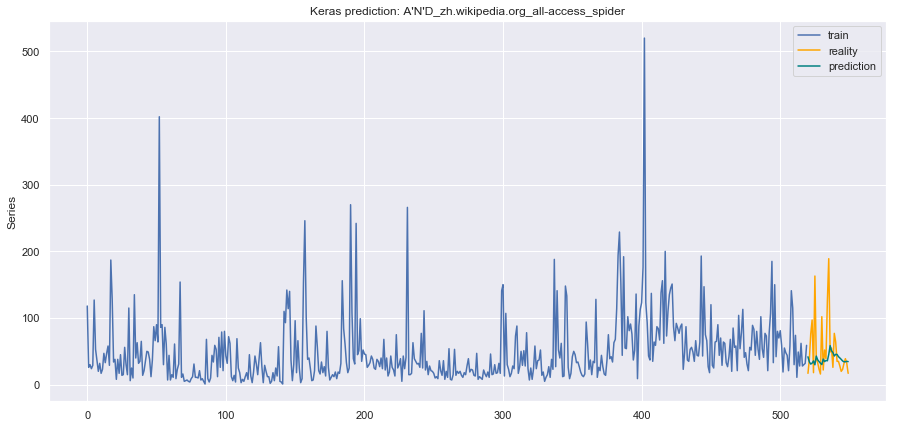

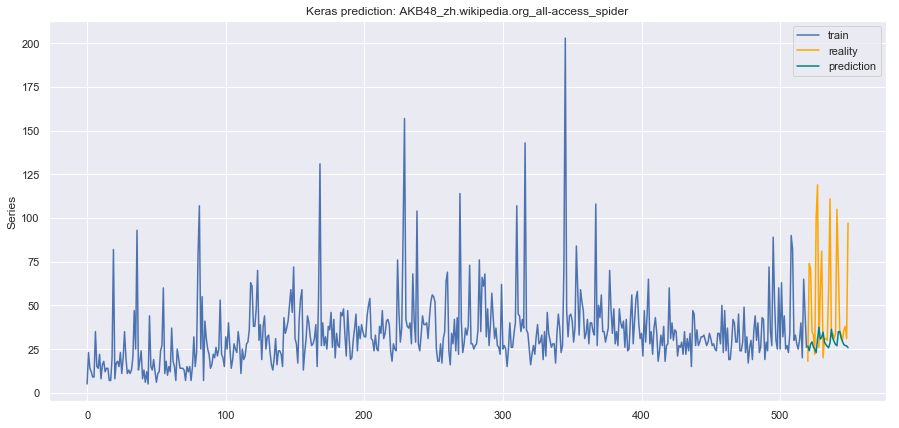

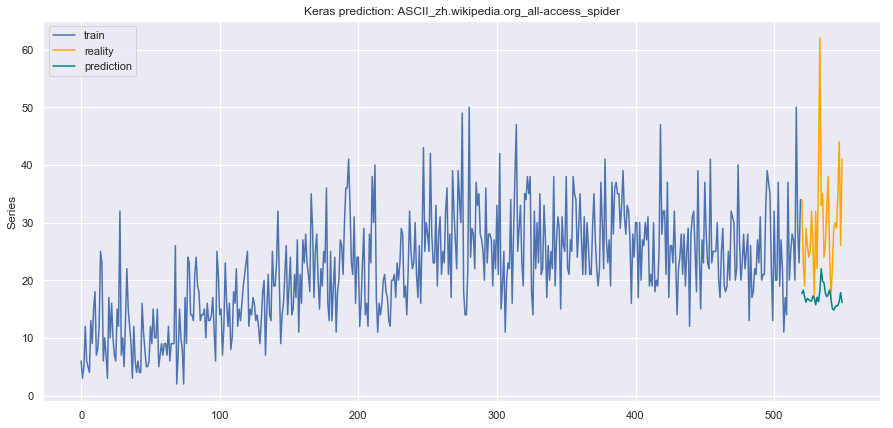

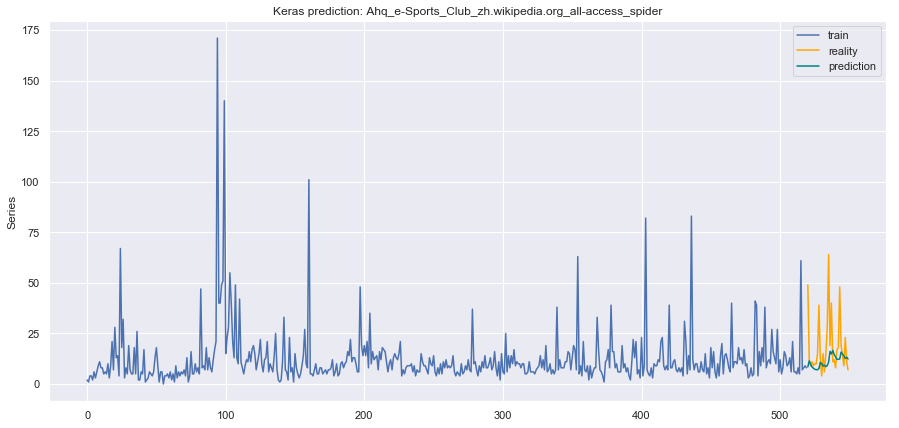

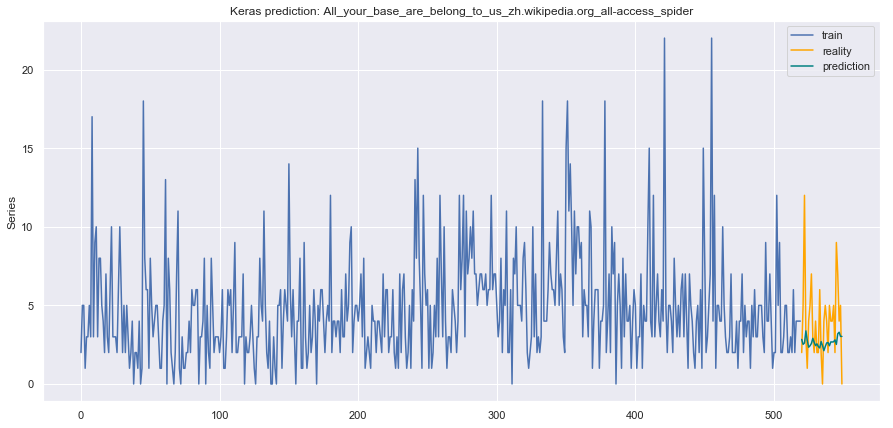

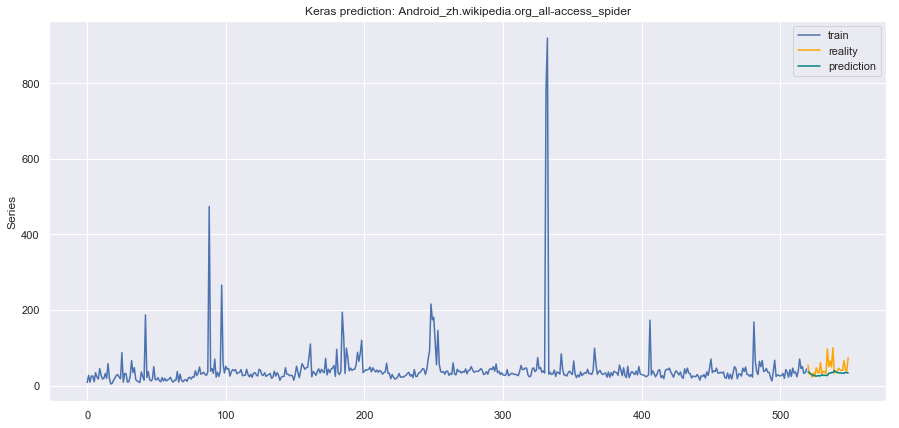

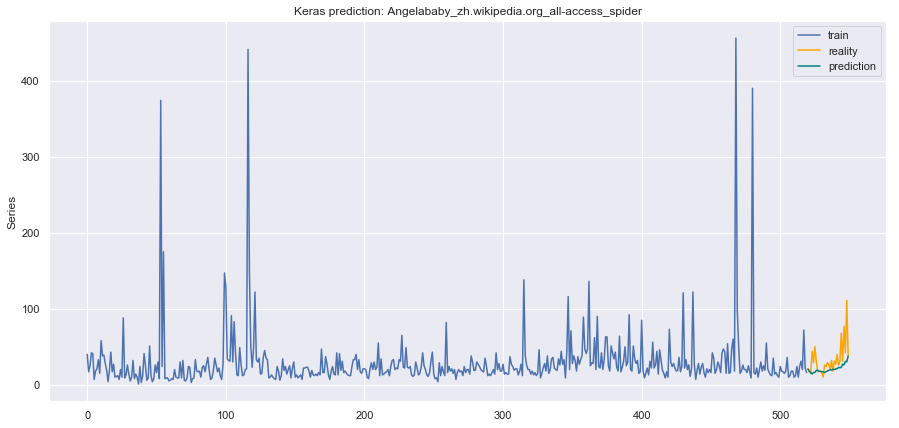

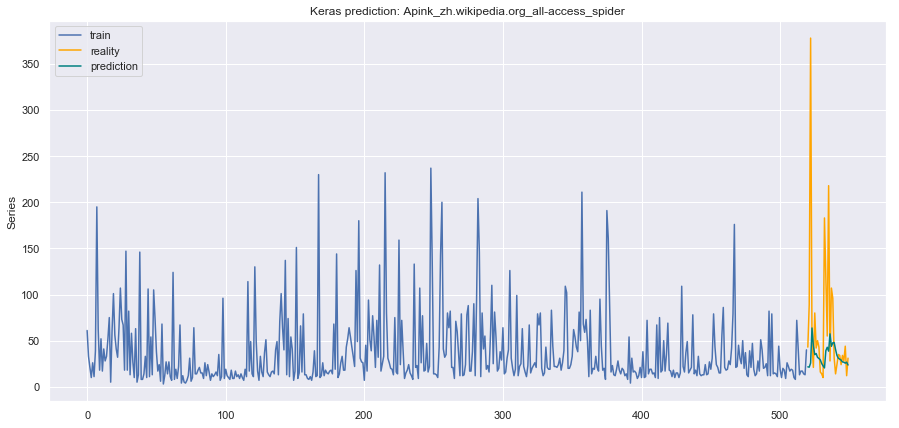

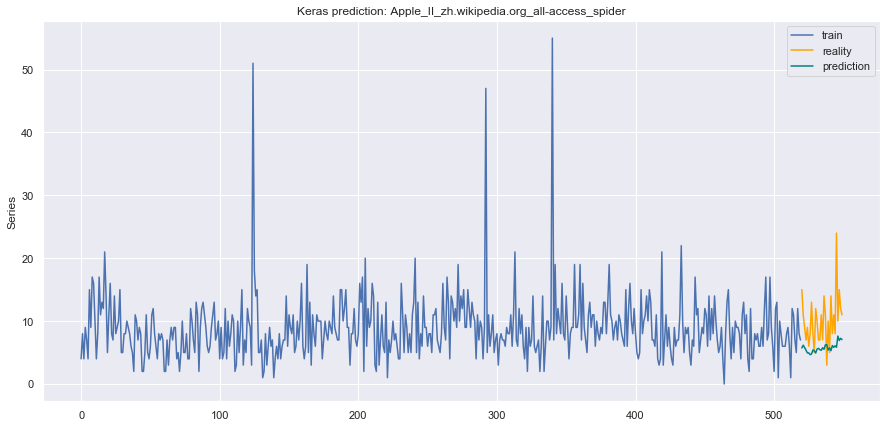

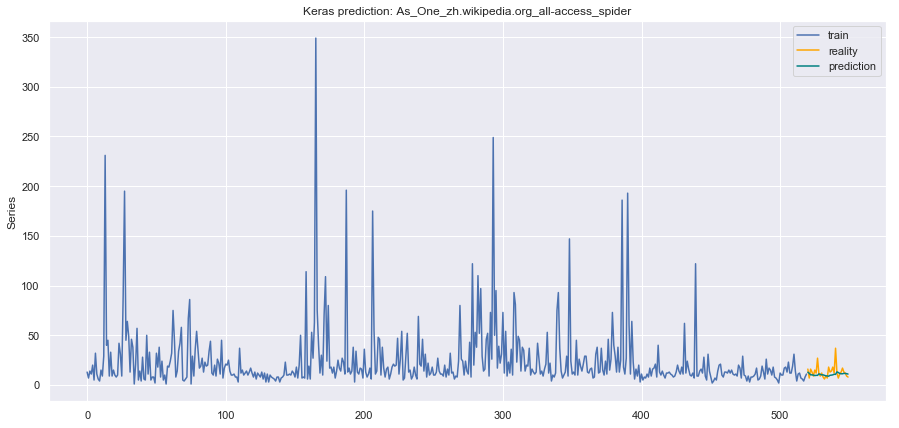

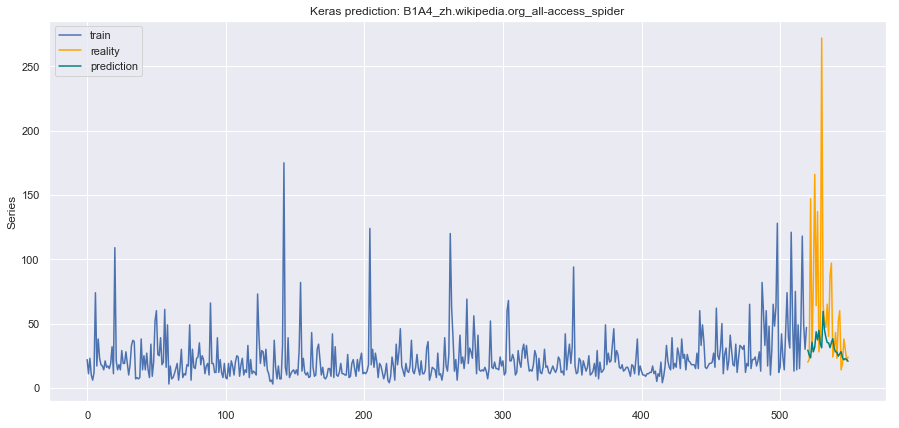

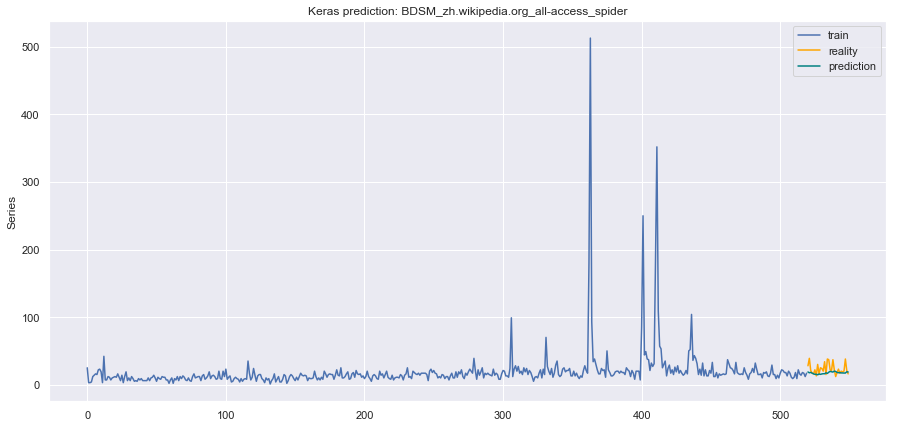

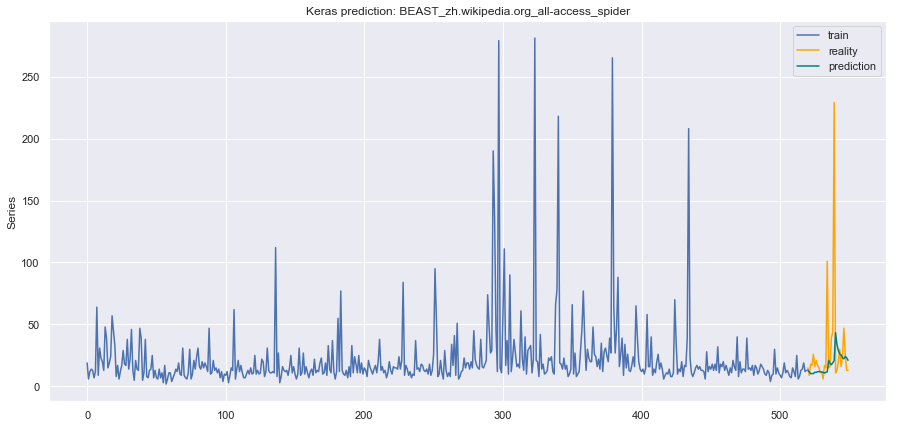

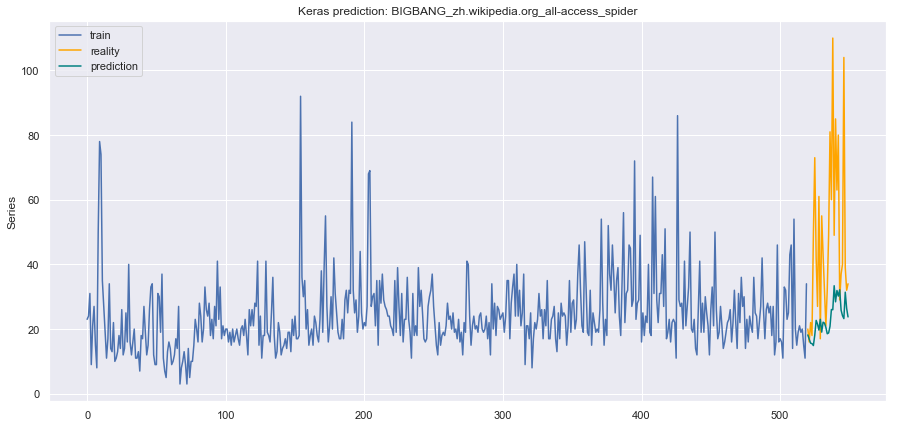

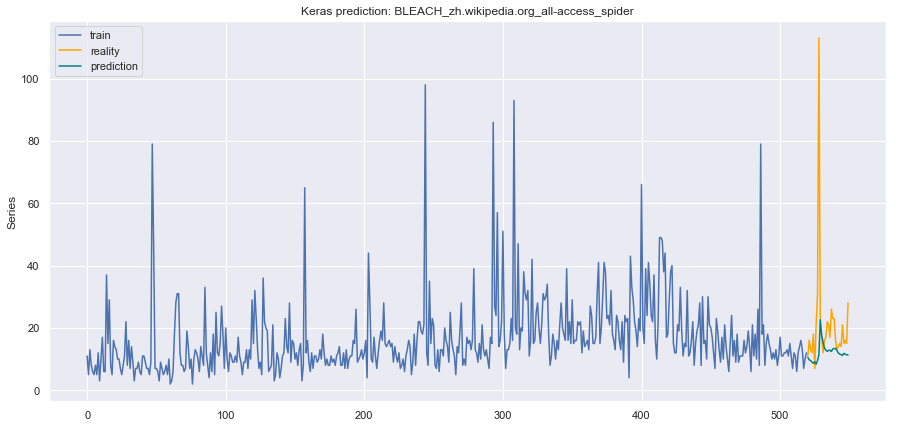

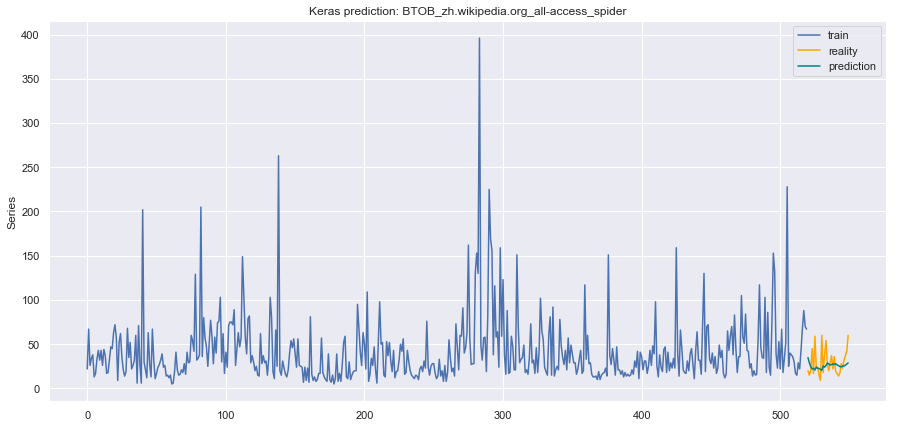

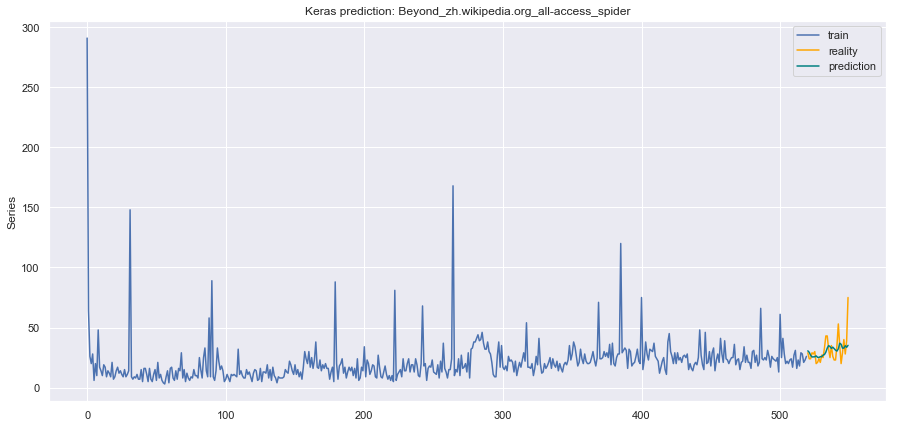

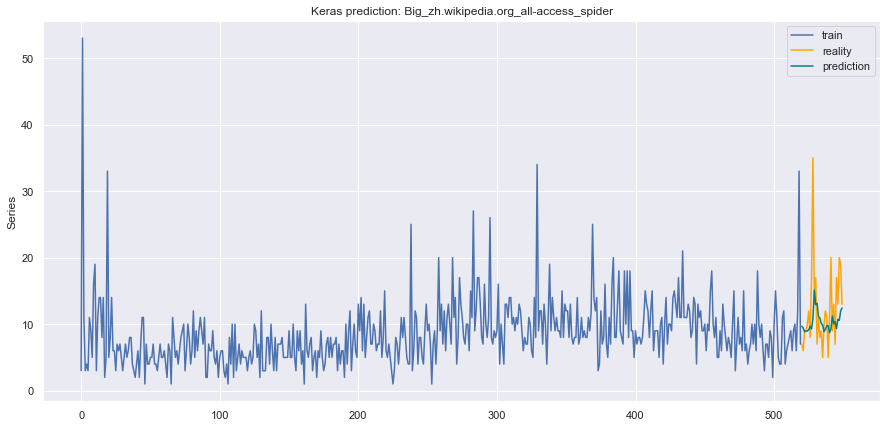

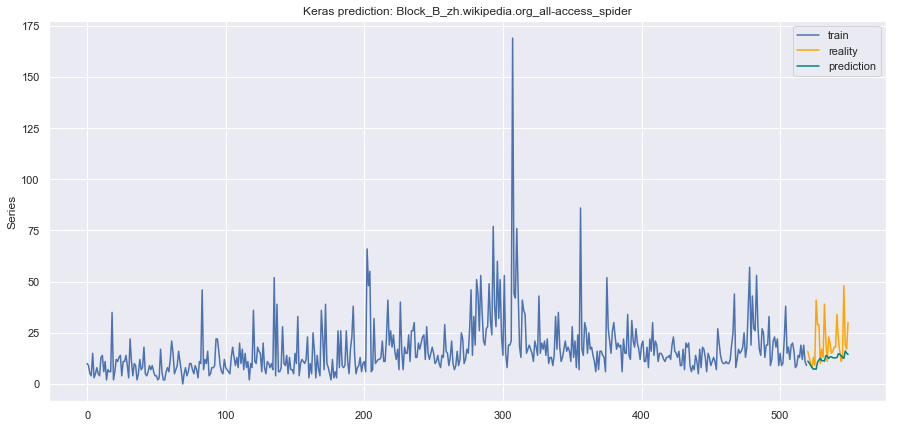

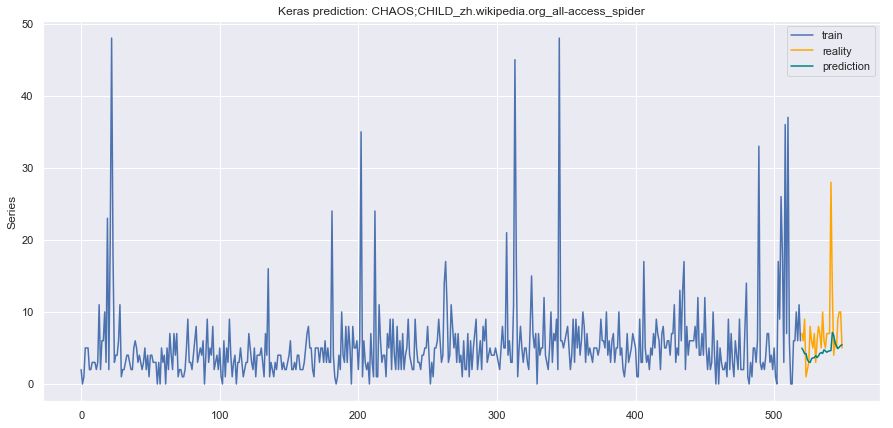

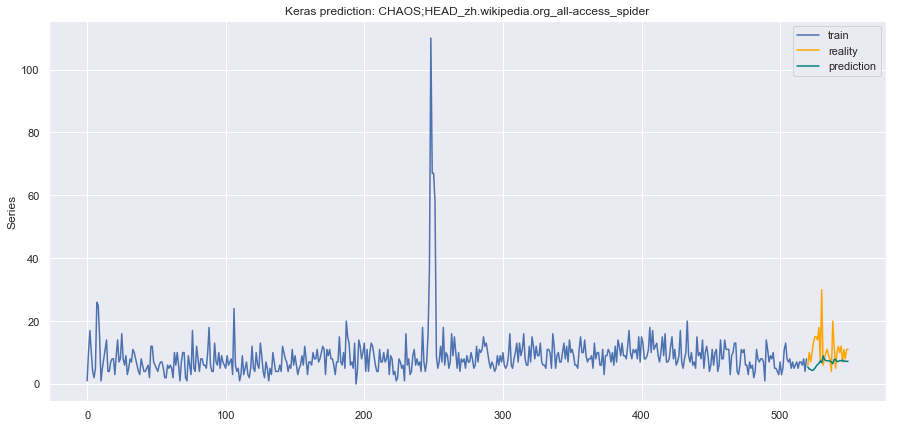

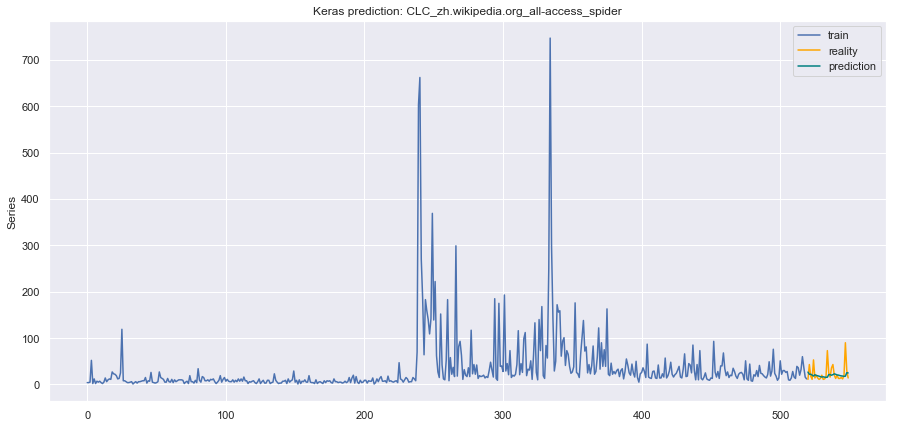

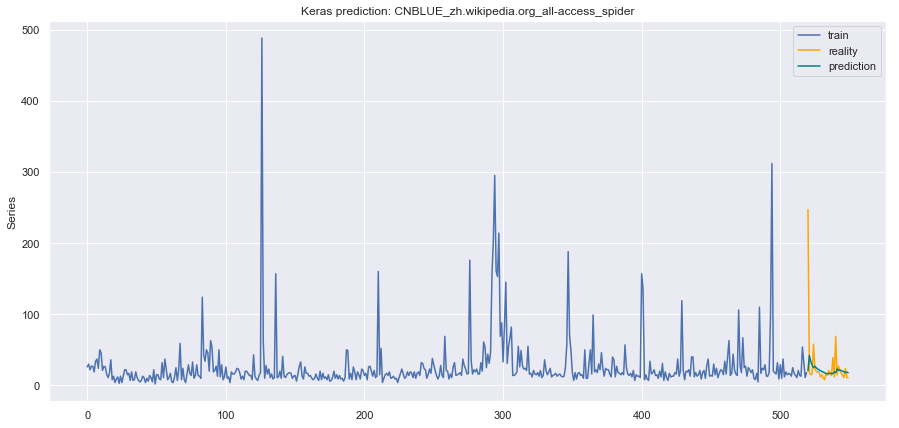

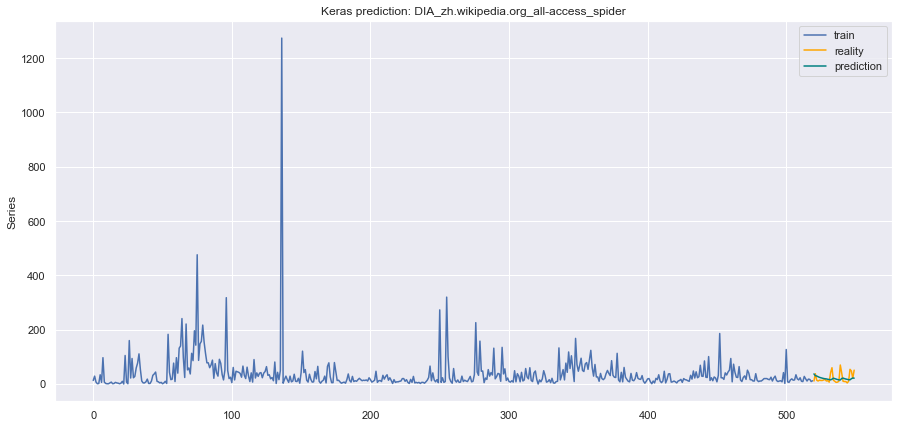

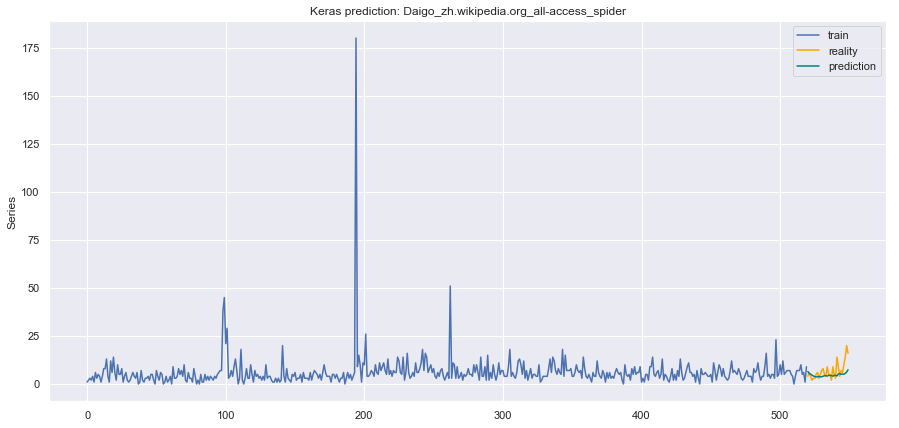

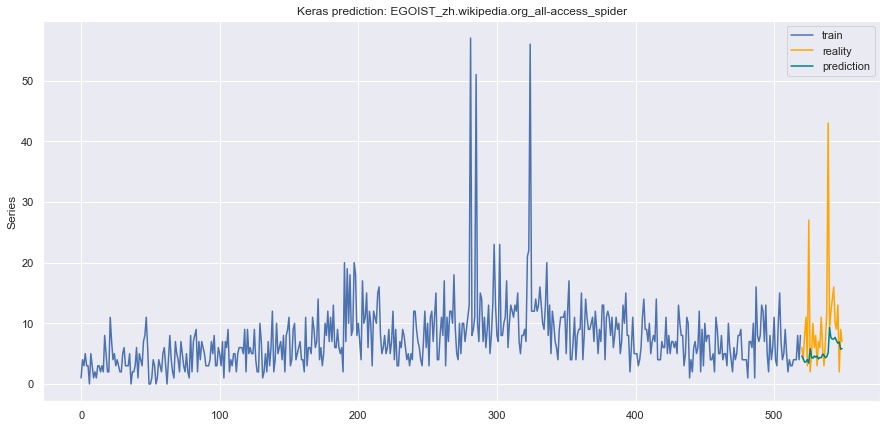

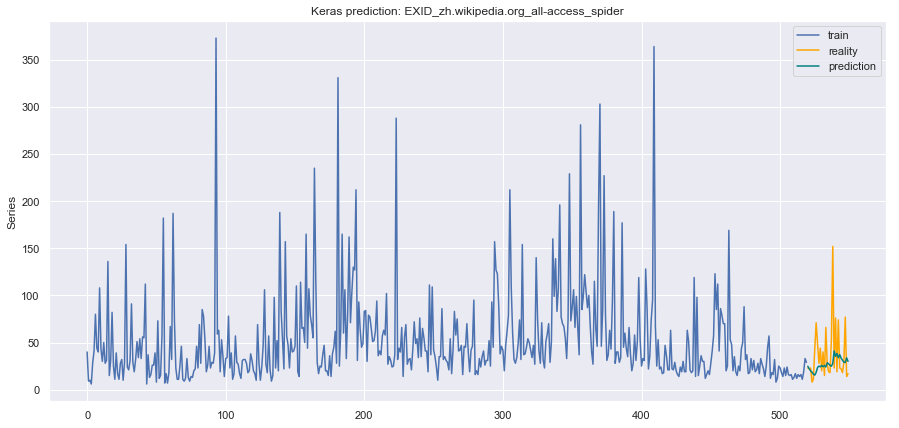

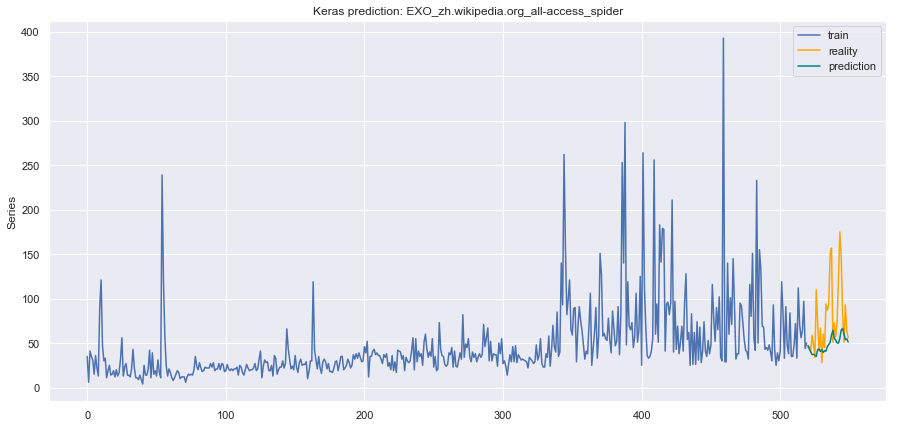

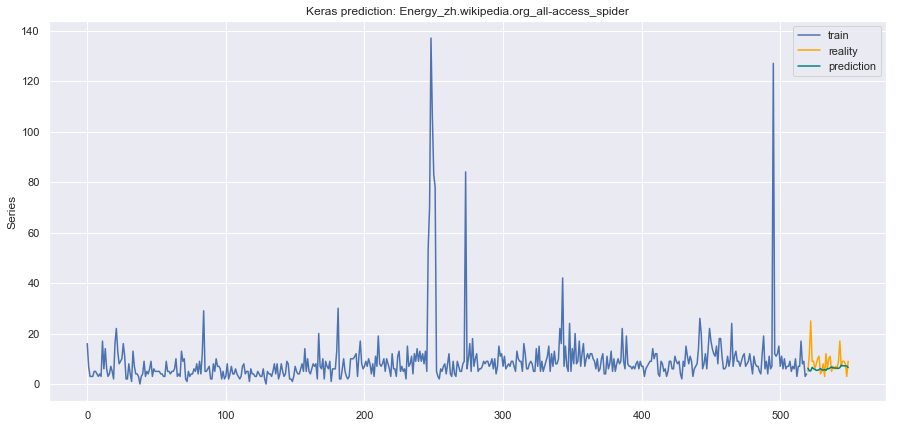

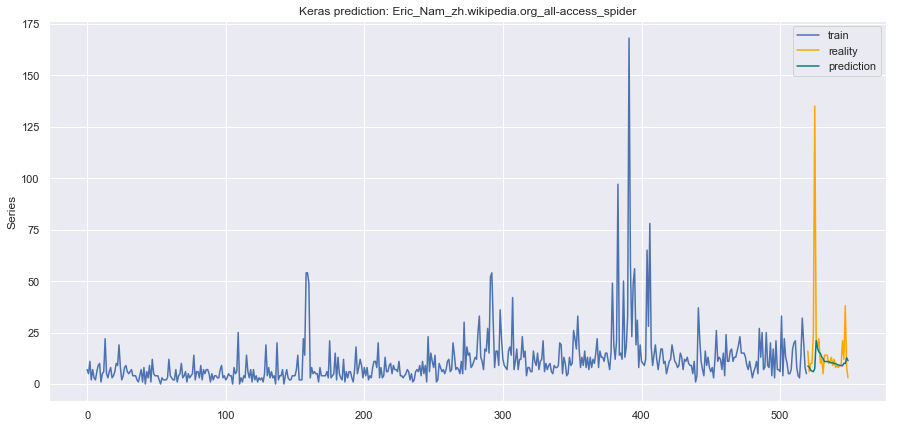

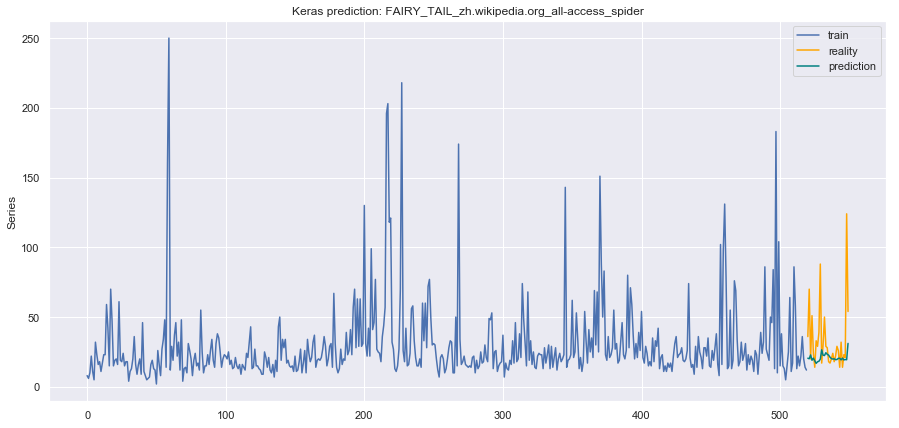

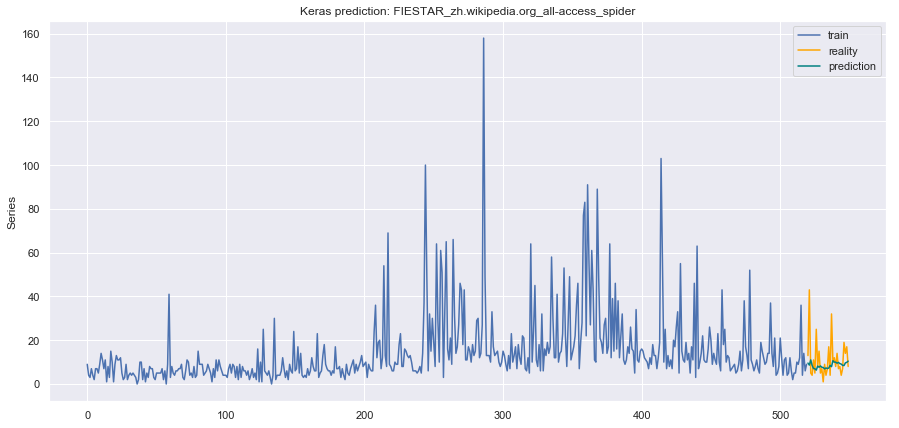

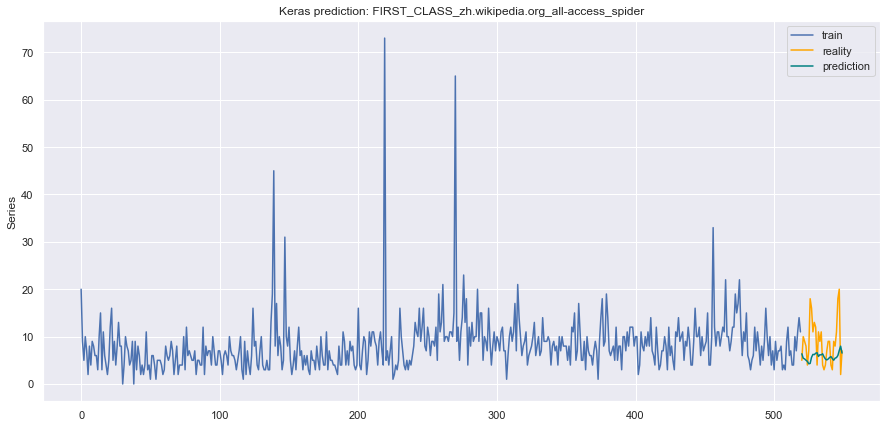

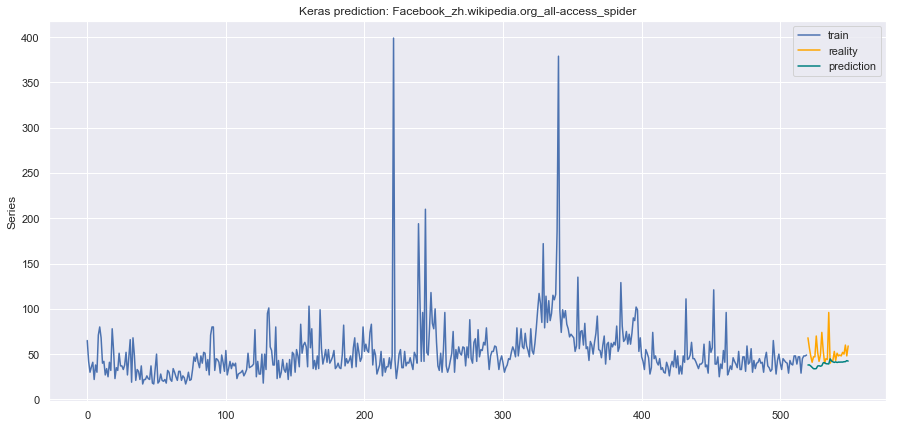

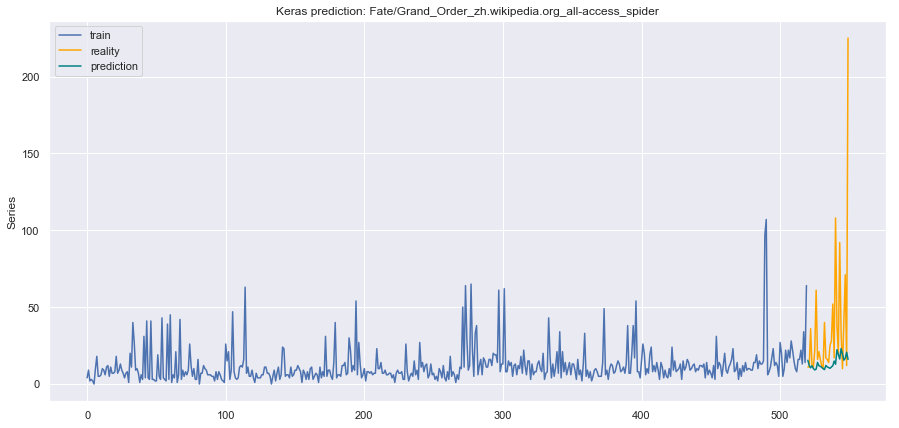

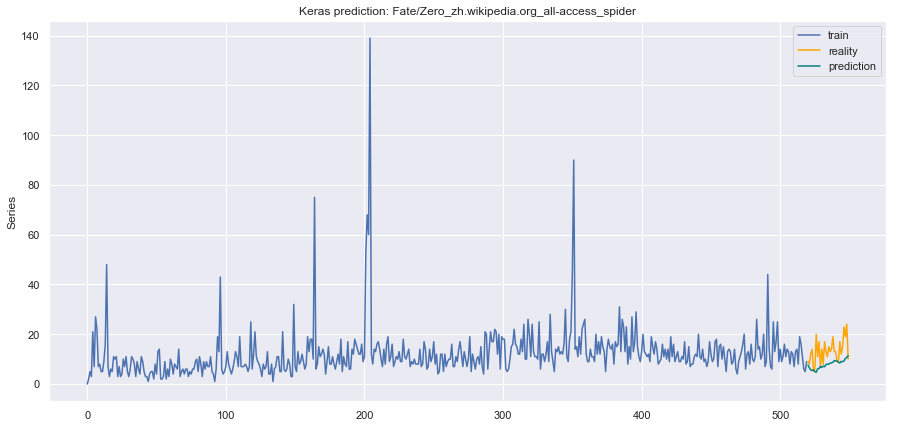

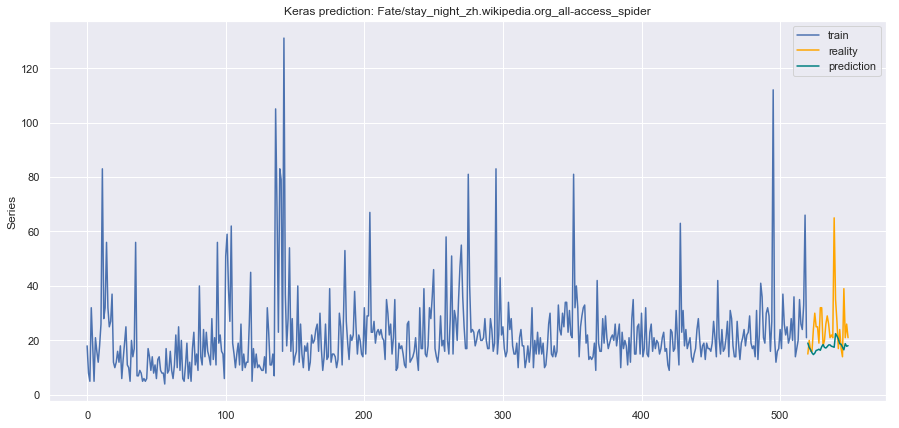

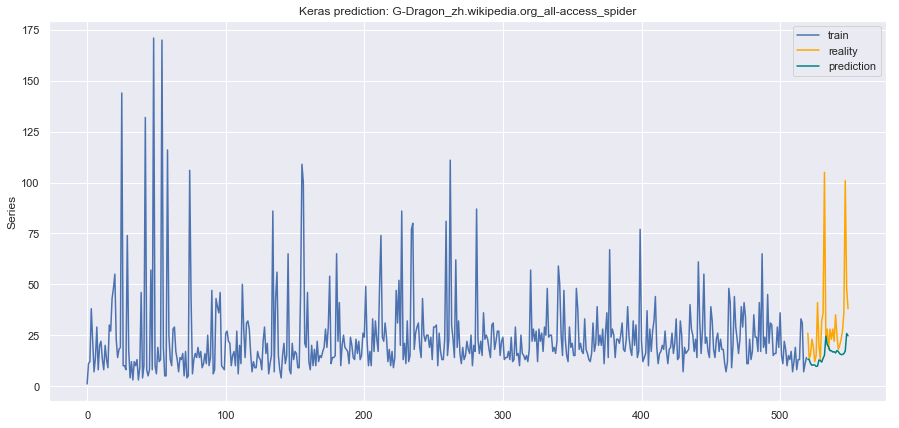

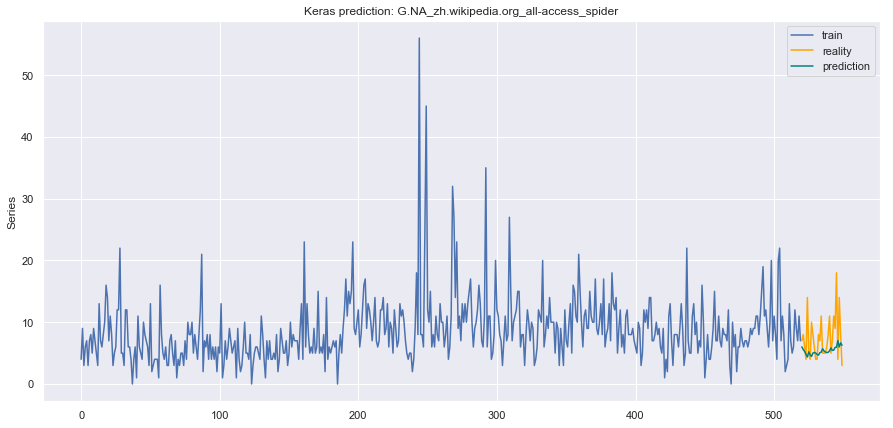

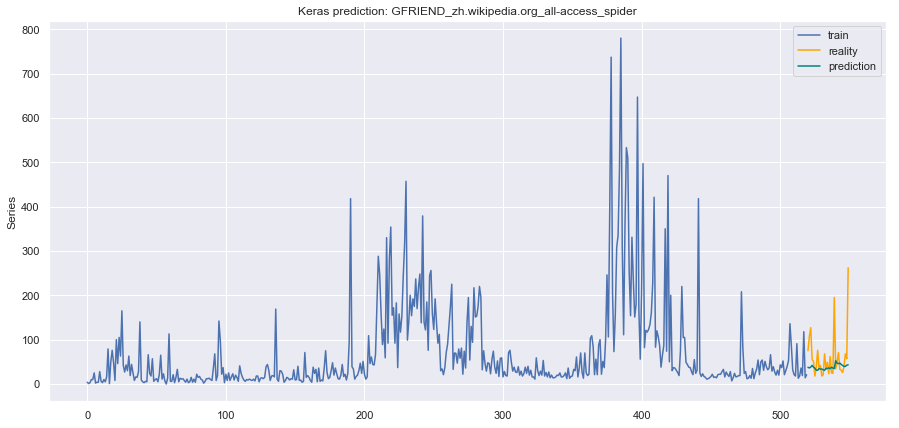

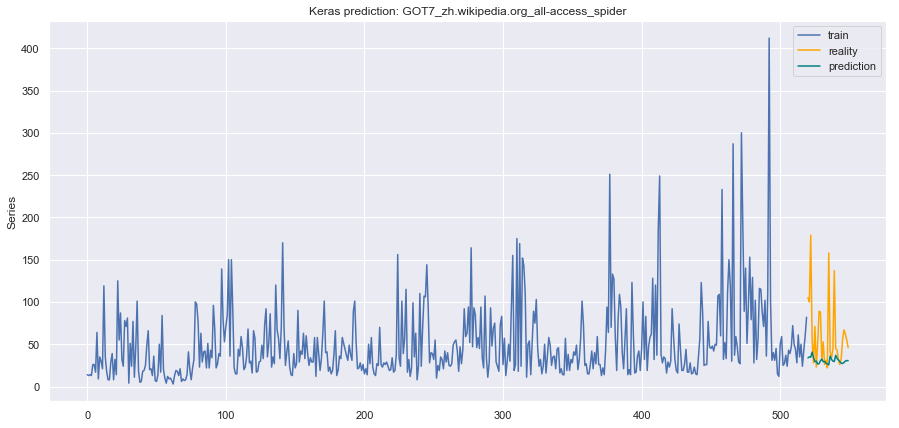

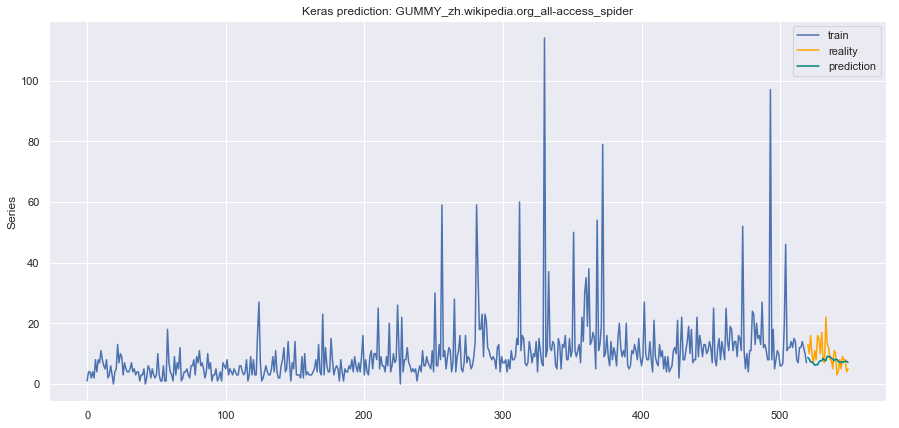

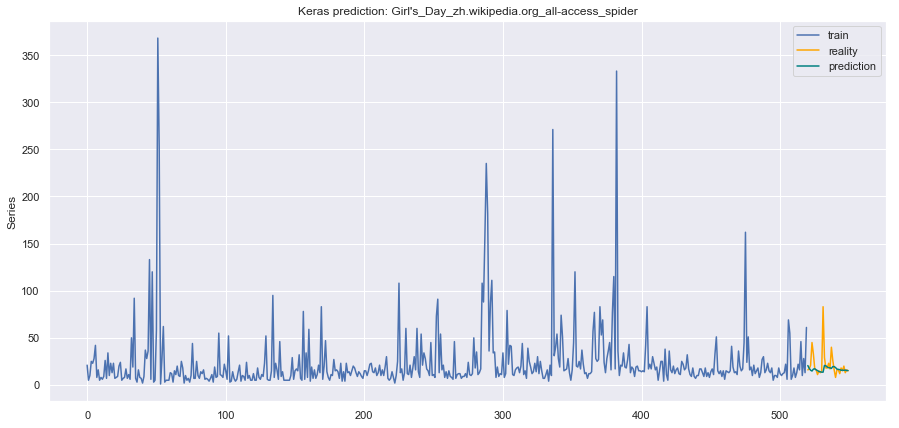

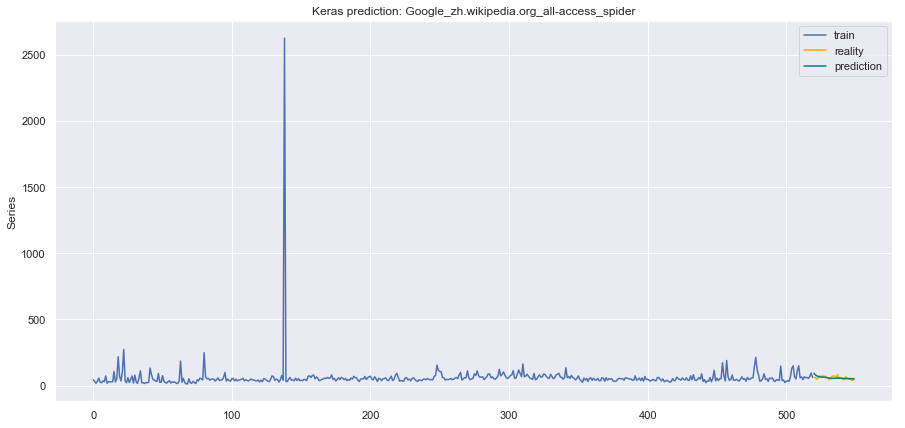

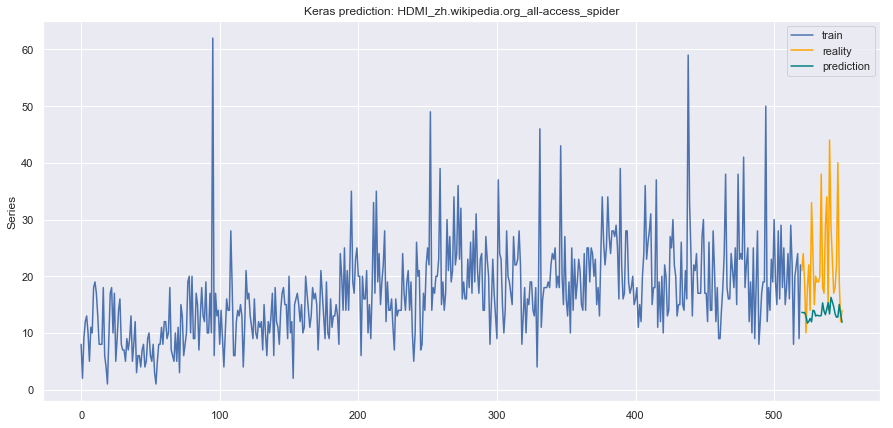

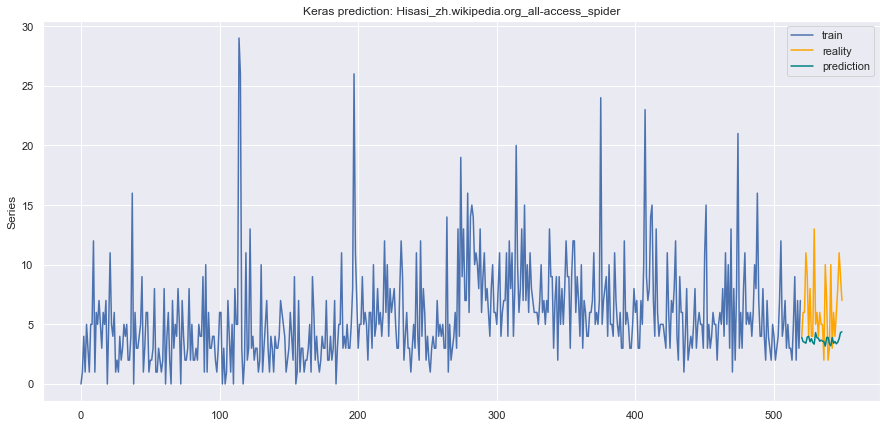

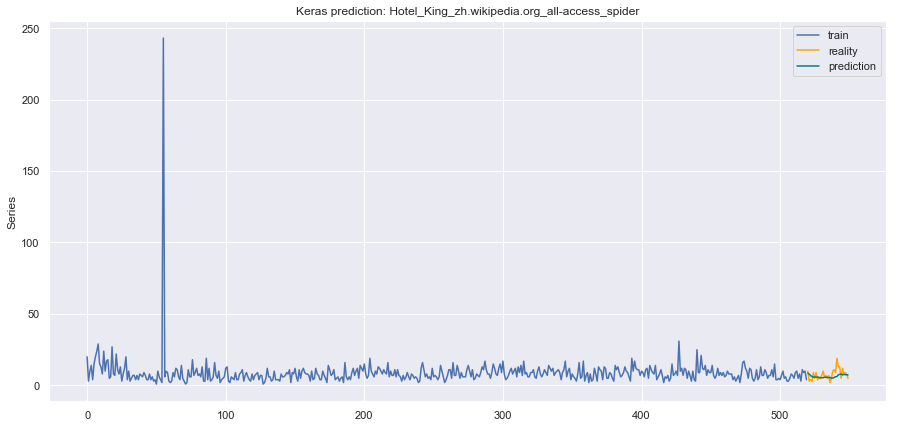

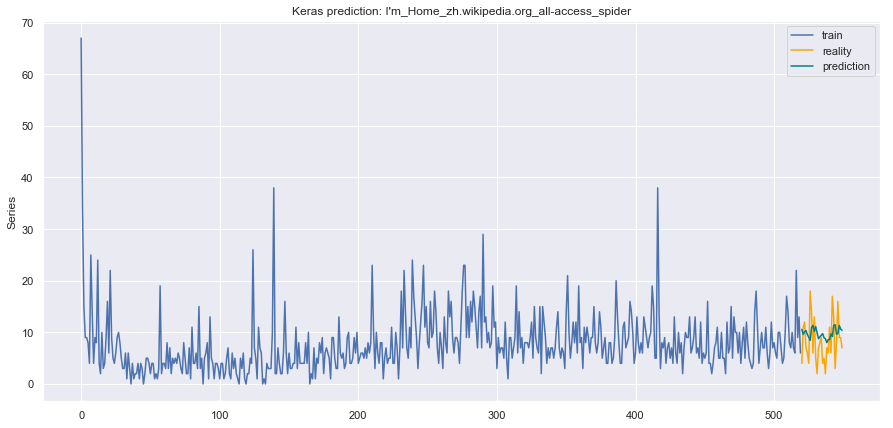

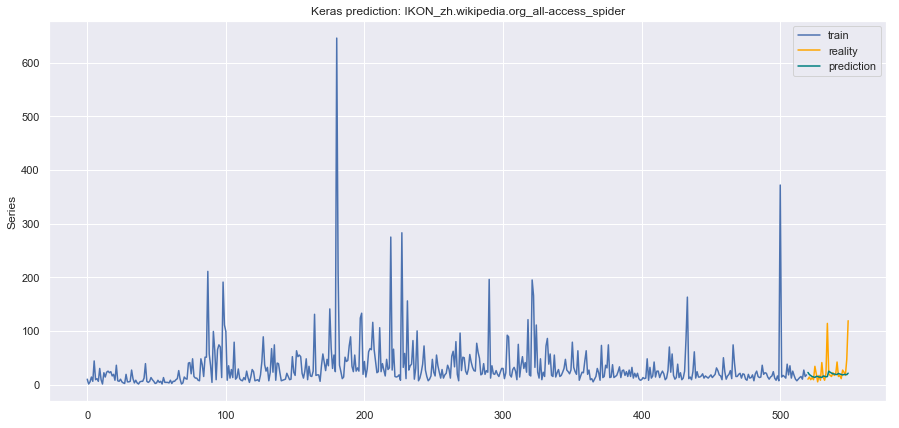

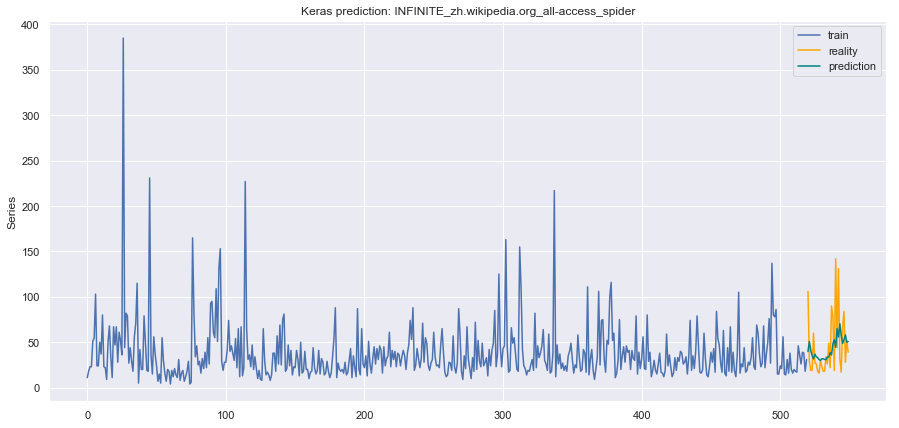

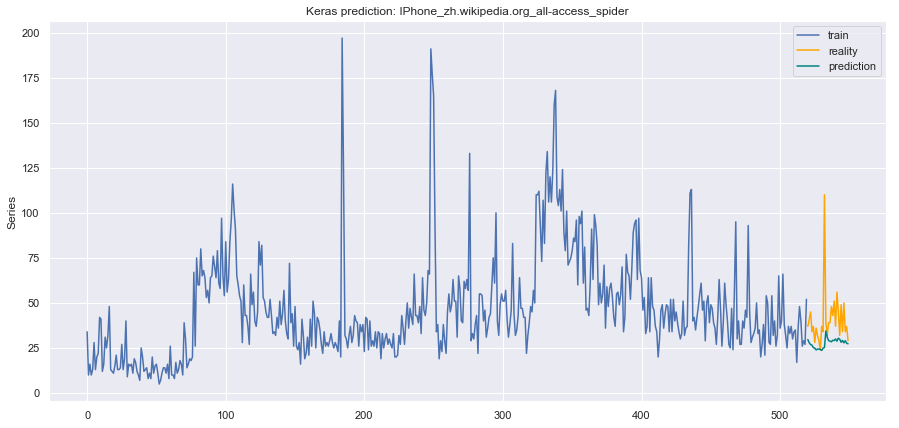

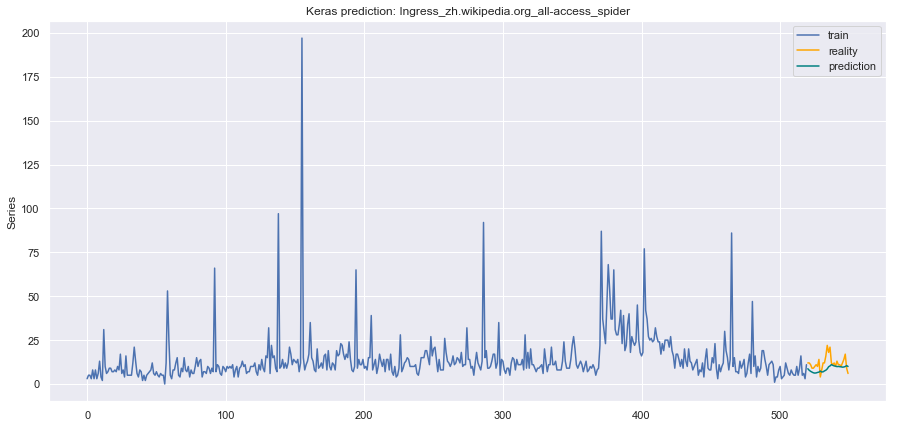

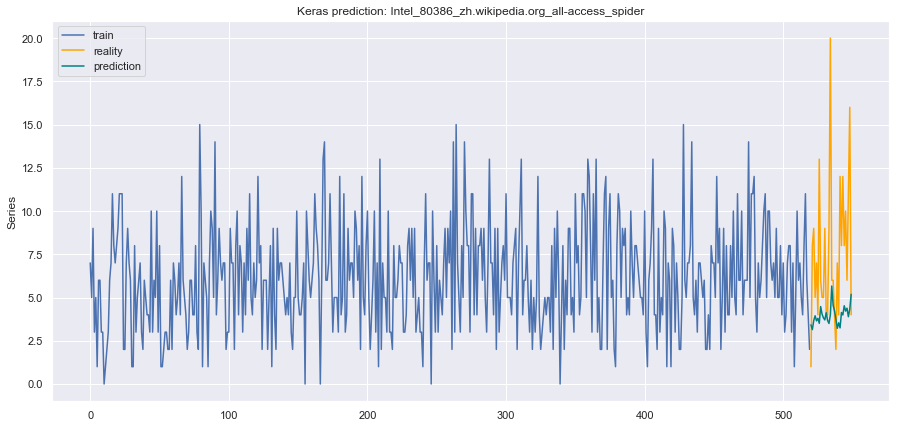

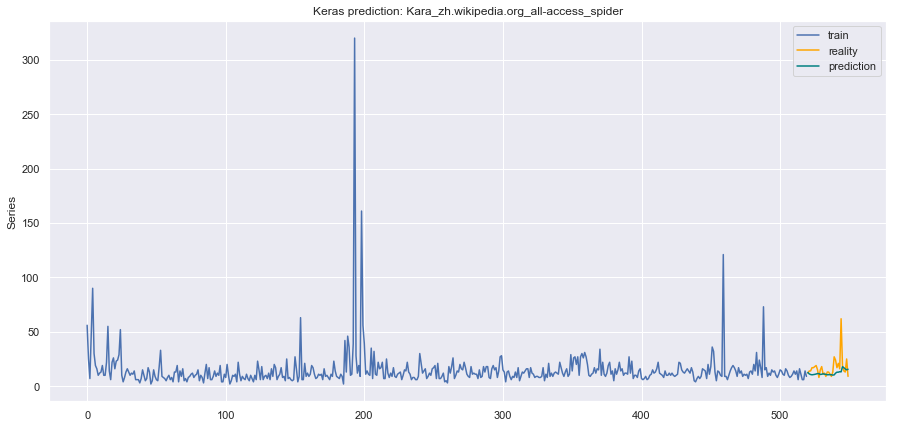

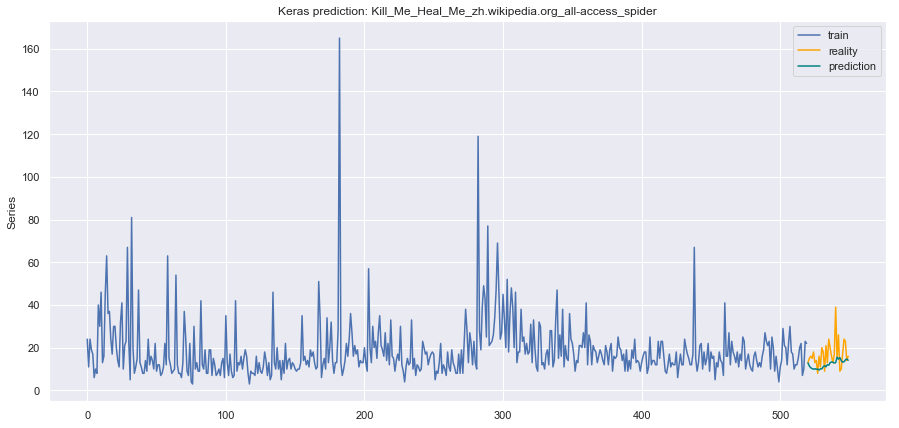

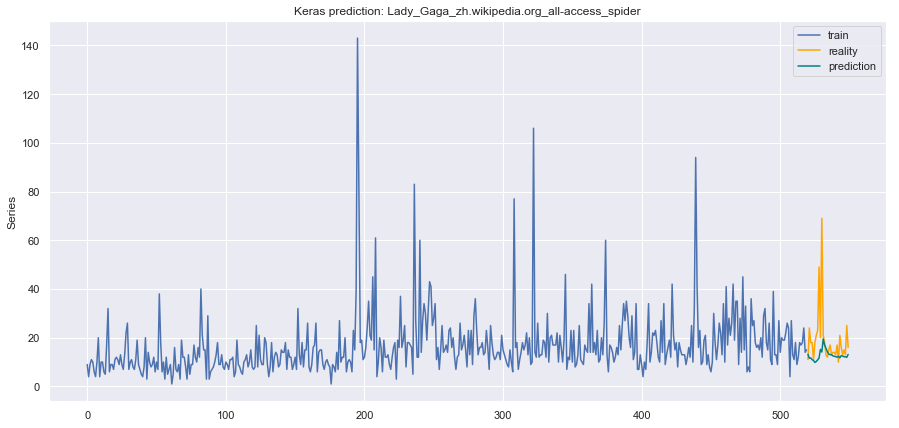

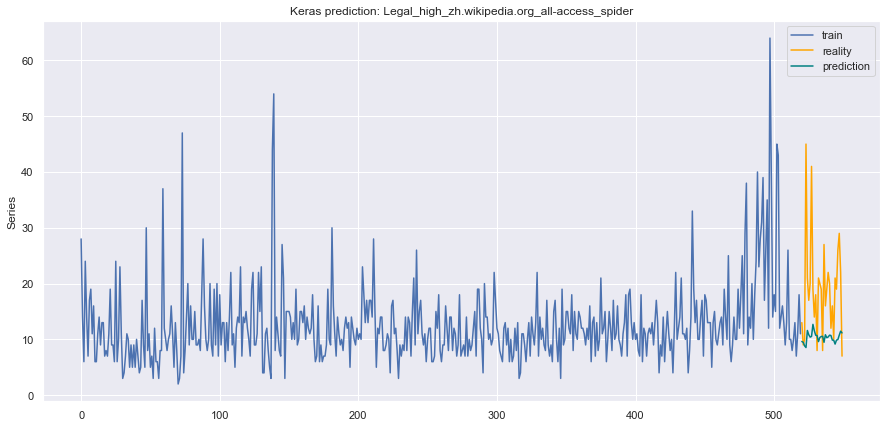

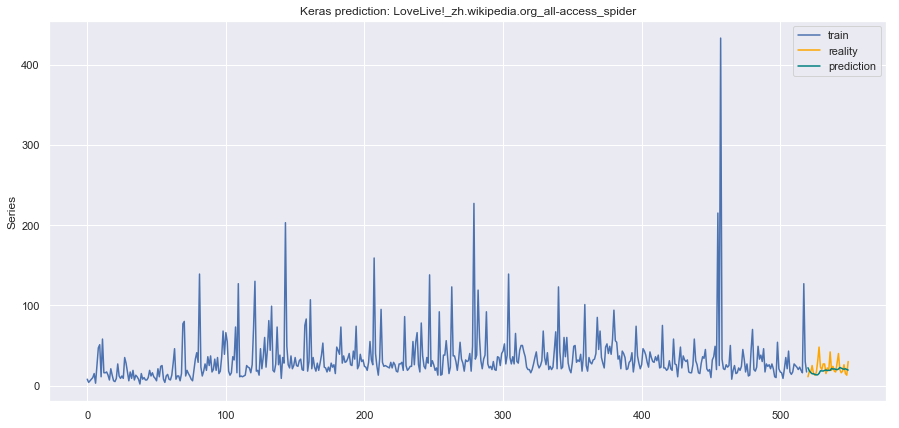

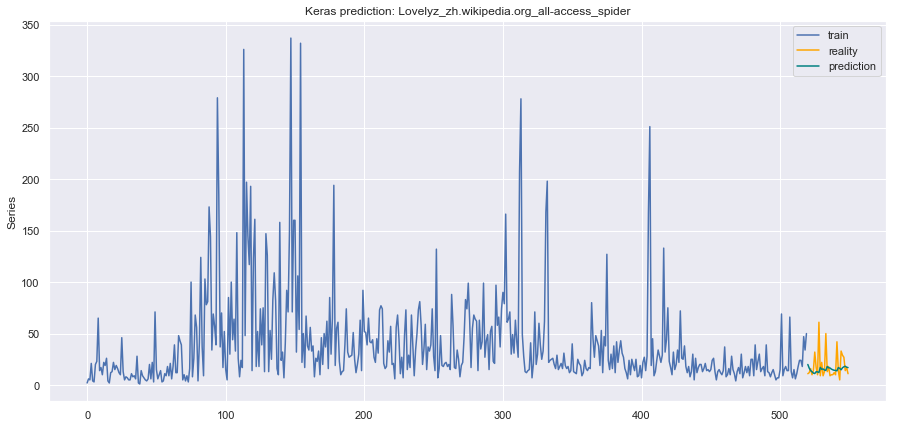

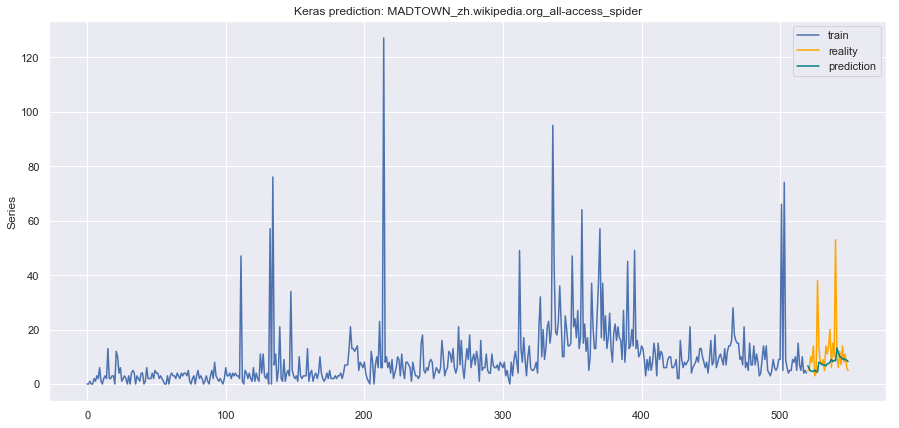

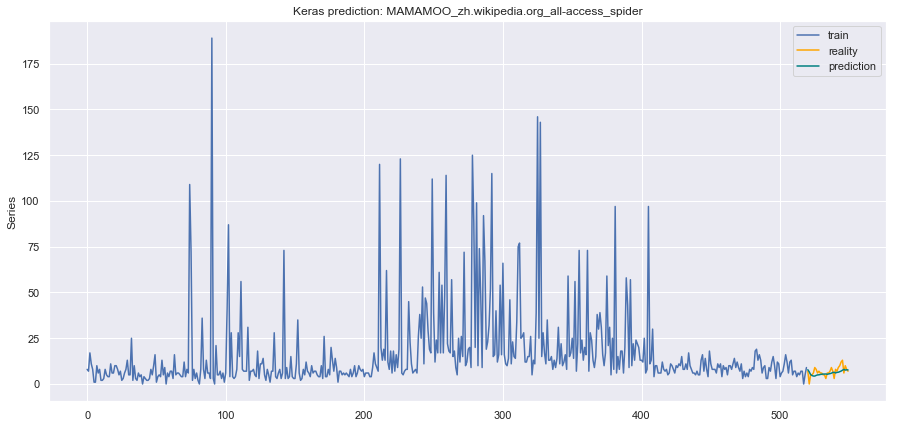

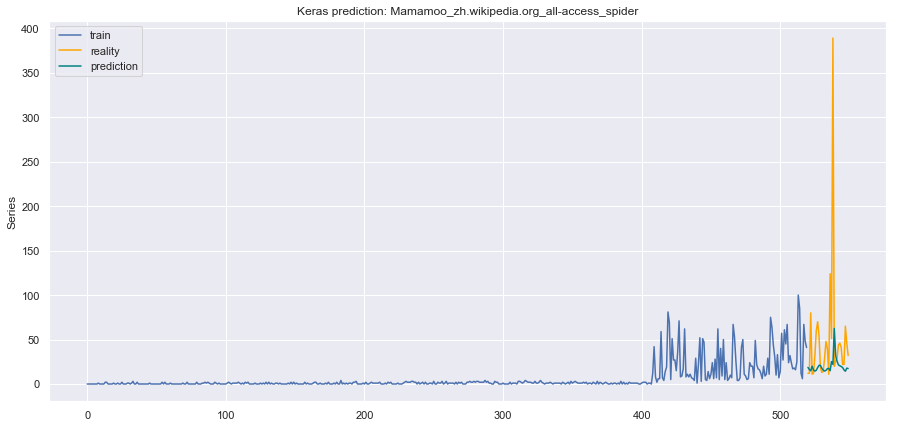

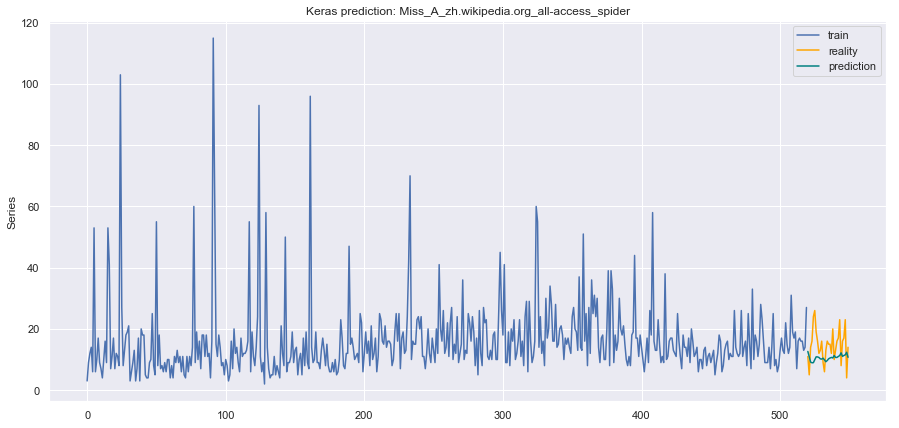

In [20]:
lookback = 1
for i in arr:
        
    train, test = series_split(page2[i], size+timestep)
    plot_keras(train, test, test.values, pred_sequences[i], lookback, titles[i])  
